# Lab 7: Multirate Signal Processing and Signal Processing Applications
## Due Date: 5/1 @11:59pm

We will primarily focus on multirate signal processing - upsampling and downsampling - in this lab. We will wrap up the lab with a look at a signal processing application beyond the scope of ECE 310, but of interest in future signal processing courses.

## Multirate Signal Processing

In many signal processing applications, we would like to change the sampling rate of our digital system. This could mean either reducing or increasing our effective sampling rate. One possibility is to perform digital-to-analog (D/A) conversion, then resample our signal in the time domain to the desired rate. However, this process requires access to the desired resampling circuitry in addition to potential artifacts introduced by the D/A conversion and quantization effects when resampling the signal.

The preferred method is to perform rate conversion in the discrete sample domain. We may increase our sampling rate via a process known as upsampling or interpolation, while we may decrease our sampling rate using downsampling or decimation. In the following background sections, we will discuss the mathematical construction of upsampling and downsampling, and also discuss some practical considerations that must be made when working on multirate signal processing.

## Upsampling

Upsampling (or interpolation) by an integer factor of $U$ is accomplished by interpolating $U-1$ zeros after every entry in our original sequence. Let $x[n]$ be our original signal. Then our upsampled signal $y[n]$ will be as follows:

$$
y[n] = \begin{cases}
x\left[\frac{n}{U}\right],\quad n = \pm U, 2U, \ldots, kU\\
0, \quad \textrm{else}\\
\end{cases}
$$

$$
y[n] = \left[x[0]\quad\underbrace{0\quad 0\quad\ldots\quad0}_{U-1\textrm{ zeros}}\quad x[1]\quad\underbrace{0\quad 0\quad\ldots\quad0}_{U-1\textrm{ zeros}}\quad x[2]\quad\ldots\quad\right]
$$

The resulting DTFT for $y[n]$ may be derived as follows:

$$
Y_d(\omega) = \sum_{n=-\infty}^\infty y[n]e^{-j\omega n}
$$

$$
= \sum_{n=-\infty}^\infty x[n] e^{-j\omega nU}
$$

$$
Y_d(\omega) = X_d(U\omega).
$$

The second line above follows from the definition of $y[n]$ since the $n$'th value of $x[n]$ is actually the $Un$'th value of $y[n]$ and all other values of $y[n]$ are zero. Thus we see the resulting spectrum will be "compressed" along the frequency axis by a factor of $U$ while maintaining the same height. The issue here is that some of our adjacent $2\pi$ periodic copies of $X_d(\omega)$ will cross over into the central copy of $Y_d(\omega)$ after upsampling. This is readily apparent when we check that $Y_d(\pi) = X_d(\pi U)$, which must be greater than the $\pi$ limits of our central copy.

The simple solution is to place a low-pass filter after our upsampler to make sure we only extract the frequencies corresponding to the central copy of our original spectrum. We see that the bandwidth of this filter should be such that our cutoff frequency $\omega_c$ maps to $\pi$ in our original specturm $X_d(\omega)$. Thus, we would like $\omega_c = \frac{\pi}{U}$. Formally, our low-pass filter $A(\omega)$ will be given by

$$
A(\omega) = \begin{cases}
1, \quad |\omega| \leq \frac{\pi}{U}\\
0, \quad \frac{\pi}{U} < |\omega| \leq \pi\\
\end{cases}.
$$

This low-pass filter accomplishes the very important task of interpolating over the zeros we placed in between our original signal values. Think of the low-pass filter as "filling in the blanks" or inferring the newly interpolated information. In summary, upsampling by a factor $U$ involves interpolating $U-1$ zeros between each sample in our original signal and then low-pass filtering with a cutoff frequency of $\frac{\pi}{U}$ to prevent the inclusion of spurious frequencies presented by adjacent DTFT copies in the original signal.

## Downsampling

Downsampling (or decimation) by an integer factor $D$ is performed by only keeping every $D$'th sample in the original signal. Let $x[n]$ be our original signal. Our downsampled signal $y[n]$ is given by

$$
y[n] = x[Dn]
$$

$$
y[n] = \left[x[0]\quad x[D]\quad x[2D]\quad\ldots\quad\right]
$$

We will skip the derivation of $Y_d(\omega)$ since it is more involved than the derivation for the interpolation case. Refer to your ECE 310 textbook for the full details. The DTFT of our decimated signal $Y_d(\omega)$ is given by

$$
Y_d(\omega) = \frac{1}{D}\sum_{k=0}^{D-1}X_d\left(\frac{\omega - 2\pi k}{D}\right).
$$

Qualitatively, we see that the input spectrum will be scaled down by a factor of $\frac{1}{D}$ and the frequency axis is stretched by a factor of $D$. It is very important, however, to note that the above form assumes an appropriate anti-aliasing filter has been applied to the input signal prior to decimation. What should this filter look like? The anti-aliasing filter should remove all frequencies that would push into adjacent DTFT copies after decimation and cause aliasing. We know that the frequency axis will expand by a factor of $D$; thus, we know any frequencies beyond $\frac{\pi}{D}$ would stretch beyond $\pi$ and alias. Consequently, our anti-aliasing filter $H(\omega)$ should have the following form:

$$
H(\omega) = \begin{cases}
1, \quad |\omega| \leq \frac{\pi}{D}\\
0, \quad \frac{\pi}{D} < |\omega| \leq \pi\\
\end{cases}.
$$

We observe that if we have a multirate signal processing system that interpolates and decimates by the same factor, we will be able to use one filter for both upsampling and downsampling! The difference, of course, is that we filter before decimation and after interpolation. In summary, downsampling by a factor of $D$ requires us to first apply a low-pass anti-aliasing filter with cutoff frequency $\frac{\pi}{D}$ then discard (or decimate) every sample that is not located at a multiiple of $D$. 

## Rate Conversion by $\frac{U}{D}$

One final topic we should mention is the concatenation of multiple rate conversion systems to achieve an arbitrary sampling rate. Suppose we would like to increase our sampling rate by a non-integer factor like $\frac{4}{3}$. How can you interpolate $\frac{1}{3}$ of a zero? You cannot! Instead, we may accomplish this new sampling rate by first upsampling by a factor of 4, then downsampling by a factor of 3. Furthermore, note that in this case the post-interpolation filter will have a cutoff frequency of $\frac{\pi}{4}$ and thus eliminate the need for our anti-aliasing filter before decimation since $\frac{\pi}{4}<\frac{\pi}{3}$! We may achieve any new sampling rate by the same procedure with appropriate anti-aliasing filters.

In [6]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from skimage.io import imread
from skimage.io import imsave

#Provided function with triangle magnitude spectrum
def toy_signal(w_c):
    N = 1000
    gain = 2*np.pi/w_c
    return gain * np.array([(np.sin(w_c/2*(n+1))/(np.pi*(n+1)))**2 if n+1 != 0 else (w_c/(2*np.pi))**2 for n in range(-N,N+1)])

%matplotlib inline

# Exercise 1: Upsampling

We will begin by exploring and verifying the above theoretical discussion regarding upsampling.

a. Fill in the below function $\textrm{upsample}(U,x)$ to perform interpolation by a factor of $U$ on an input signal $x$. Verify your function correctly interpolates zeros by printing the provided test signal before and after upsampling for some integer $U$.

b. The provided function $\textrm{toy_signal}(\omega_c)$ creates a toy signal that has a triangular magnitude response with bandwidth $\omega_c$. More precisely, if our toy signal is given by $x$, the magnitude of the DTFT of this toy signal will be

$$
|X_d(\omega)| = \begin{cases}
-\left|\frac{\omega}{\omega_c}\right| + 1\,\quad |\omega| \leq \omega_c\\
0,\quad \omega_c \leq |\omega| \leq \pi\\
\end{cases}.
$$

Use the provided toy signal function to create a signal with bandwidth $\frac{\pi}{2}$ ($\omega_c = \frac{\pi}{2}$). Upsample this toy signal by a factor of $U=3$. Plot the magnitude of the FFT of the original and upsampled toy signals on separate subplots using $\textrm{np.fft.fft()}$. Hint: use $\textrm{np.fft.fftshift()}$ to zero-center the frequency spectrum and $\textrm{np.linspace()}$ to create your frequencies from $-\pi$ to $\pi$ for plotting.

c. Fill in the below function $\textrm{lowpass}(C)$ to create an appropriate low-pass filter that should follow interpolation by a factor of $C$. You may use $\textrm{signal.remez()}$ like in Lab 6 for Parks-McClellan filter design of a length 50 filter. You may also assume a transition bandwidth of $\frac{\pi}{10}$ (0.1 in normalized frequency). Apply your low-pass filter to your upsampled toy signal from part 1.(b). Plot the magnitude of the FFT of the filtered signal to verify the spurious DTFT copies have been removed by your filter. $\textbf{Note that this filtering function will also work as an anti-aliasing filter for decimation by a factor of } D$.

The signal before upsampling: [1 2 3 4 5 6]
The signal after upsampling by a factor of 3: [1, 0, 0, 2, 0, 0, 3, 0, 0, 4, 0, 0, 5, 0, 0, 6, 0, 0]


Text(0, 0.5, 'Magnitude')

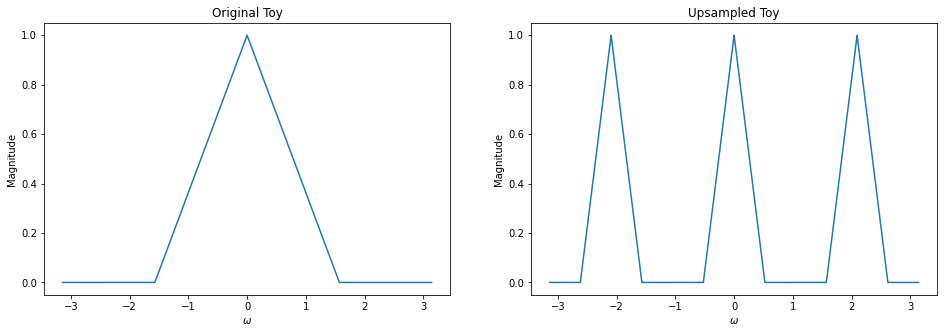

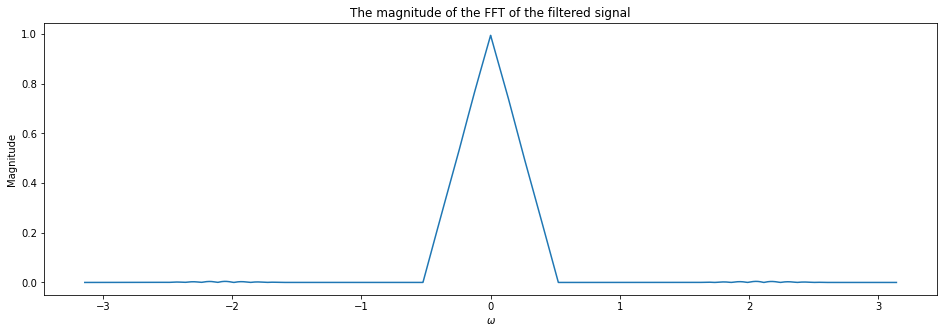

In [20]:
# Fill in this function for part 1.a:
def upsample(U, x):
    upsampled = []
    
    for i in range(len(x)):
        upsampled.append(x[i])
        for j in range(U - 1):
            upsampled.append(0)
            
    return upsampled

# Fill in this function for part 1.c:
def lowpass(C):
    filter = [0, 1/C - 1/20, 1/C + 1/20, 1]
    lpf = signal.remez(50, filter, [1, 0], fs = 2)
    
    return lpf

# Test code for part 1.a:
test_signal = np.array([1, 2, 3, 4, 5, 6])
print("The signal before upsampling:", test_signal)
print("The signal after upsampling by a factor of 3:", upsample(3, test_signal))

# Code for part 1.b:
toy_sig = toy_signal(np.pi / 2)
toy_fft = np.fft.fftshift(np.fft.fft(toy_sig))
w_toy = np.linspace(-np.pi, np.pi, len(toy_fft))

toy_upsample = upsample(3, toy_sig)
toy_upsample_fft = np.fft.fftshift(np.fft.fft(toy_upsample))
w_upsample = np.linspace(-np.pi, np.pi, len(toy_upsample_fft))

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(w_toy, abs(toy_fft))
plt.title("Original Toy")
plt.xlabel("$\omega$")
plt.ylabel("Magnitude")
plt.subplot(122)
plt.plot(w_upsample, abs(toy_upsample_fft))
plt.title("Upsampled Toy")
plt.xlabel("$\omega$")
plt.ylabel("Magnitude")

# Code for part 1.c:
filtered_sig = signal.lfilter(lowpass(3), [1,0], toy_upsamp)
filtered_fft = np.fft.fftshift(np.fft.fft(filtered_sig))
w_filtered = np.linspace(-np.pi, np.pi, len(filtered_fft))

plt.figure(figsize=(16,5))
plt.title("The magnitude of the FFT of the filtered signal")
plt.plot(w_filtered, abs(filtered_fft))
plt.xlabel("$\omega$")
plt.ylabel("Magnitude")


# Exercise 2: Downsampling

Now we will turn our attention to downsampling.

a. Fill in the below function $\textrm{downsample}(D, x)$ to perform decimation by a factor of $D$ on an input signal $x$. Verify your function correctly decimates by printing the provided test signal before and after downsampling for some integer $D$.

b. Use the provided toy signal function to create a signal with bandwidth $\frac{\pi}{2}$. Downsample this toy signal by a factor of $D=2$. Plot the magnitude of the FFT of the original and downsampled toy signals on separate subplots using $\textrm{np.fft.fft()}$ (do not forget to use $\textrm{np.fft.fftshift()}$ to center you FFT!). Do not worry about anti-aliasing filtering for now.

c. Use the provided toy signal function to create a signal with bandwidth $\frac{\pi}{2}$. Downsample this toy signal by a factor of $D=3$. Plot the magnitude of the FFT of the original and downsampled toy signals on separate subplots using $\textrm{np.fft.fft()}$. Do not worry about anti-aliasing filtering. Explain what is happening in the magnitude of the decimated signal's FFT. **Note: pay attention to the y-axis scaling when comparing parts (b) and (c), i.e. consider using plt.ylim() to set the y-axis ranges.**

d. Finally, let's use our upsampling, downsampling, and filtering functions to perform sampling rate conversion by a factor of $\frac{3}{5}$. This may be accomplished with two different schemes: downsampling followed by upsampling or upsampling followed by downsampling. These two schemes are not necessarily equivalent for a given input signal! Perform sampling rate conversion by a factor of $\frac{3}{5}$ using both schemes on a toy signal with bandwidth $\frac{\pi}{2}$. Plot the magnitude of the FFT for the final system output for each scheme. What are the differences between the two outputs? Which scheme do you think works best? Why? Note: remember to apply appropriate anti-aliasing and post-interpolation filters before and after downsampling and upsampling, respectively!

The signal before downsampling: [1 2 3 4 5 6]
The signal after downsampling by a factor of 2: [1, 3, 5]


Text(0, 0.5, 'Magnitude')

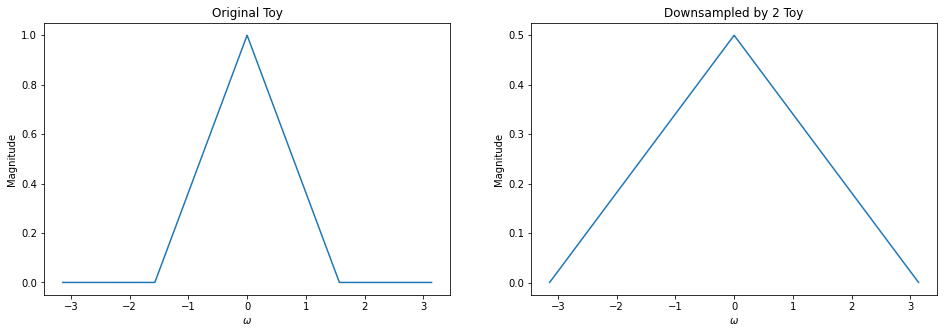

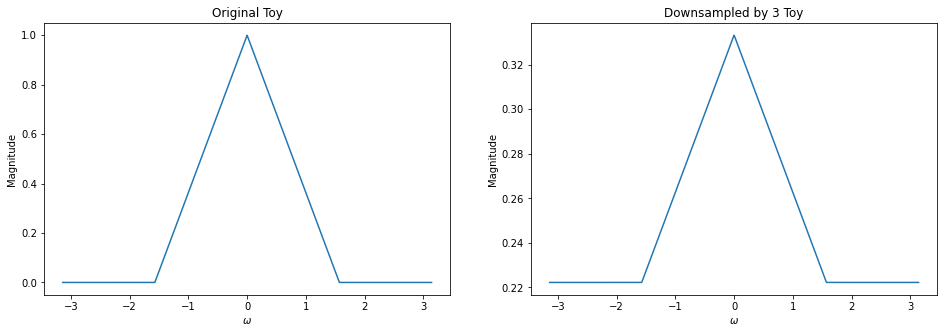

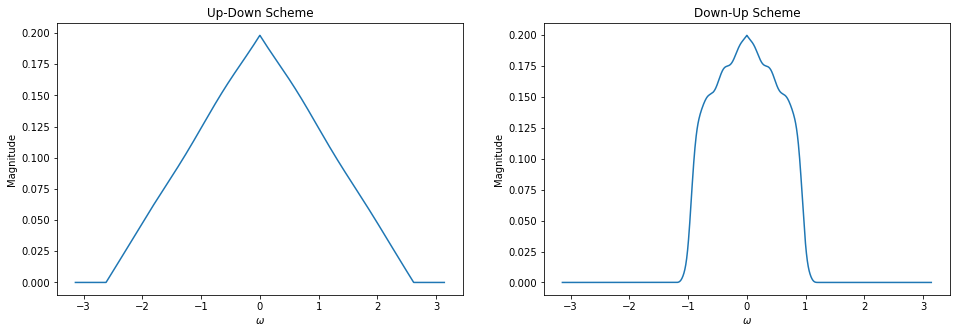

In [32]:
# Fill in this function for part 2.a:
def downsample(D, x):
    downsampled = []
    
    for i in range(len(x)):
        if i % D == 0:
            downsampled.append(x[i])
            
    return downsampled

# Test code for part 2.a:
test_signal = np.array([1, 2, 3, 4, 5, 6])
print("The signal before downsampling:", test_signal)
print("The signal after downsampling by a factor of 2:", downsample(2, test_signal))

# Code for part 2.b:
toy_downsample2 = downsample(2, toy_sig)
toy_downsample2_fft = np.fft.fftshift(np.fft.fft(toy_downsample2))
w_downsample2 = np.linspace(-np.pi, np.pi, len(toy_downsample2_fft))

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(w_toy, abs(toy_fft))
plt.title("Original Toy")
plt.xlabel("$\omega$")
plt.ylabel("Magnitude")
plt.subplot(122)
plt.plot(w_downsample2, abs(toy_downsample2_fft))
plt.title("Downsampled by 2 Toy")
plt.xlabel("$\omega$")
plt.ylabel("Magnitude")

# Code for part 2.c:
toy_downsample3 = downsample(3, toy_sig)
toy_downsample3_fft = np.fft.fftshift(np.fft.fft(toy_downsample3))
w_downsample3 = np.linspace(-np.pi, np.pi, len(toy_downsample3_fft))

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(w_toy, abs(toy_fft))
plt.title("Original Toy")
plt.xlabel("$\omega$")
plt.ylabel("Magnitude")
plt.subplot(122)
plt.plot(w_downsample3, abs(toy_downsample3_fft))
plt.title("Downsampled by 3 Toy")
plt.xlabel("$\omega$")
plt.ylabel("Magnitude")

# Code for part 2.d:
up = signal.filtfilt(lowpass(3), 1, upsample(3, toy_sig))
up_down = downsample(5, up)
up_down_fft = np.fft.fftshift(np.fft.fft(up_down))
w_up_down = np.linspace(-np.pi, np.pi, len(up_down_fft))

sig = signal.filtfilt(lowpass(5), 1,toy_sig)
down = downsample(5, sig)
down_up = signal.filtfilt(lowpass(3), 1, upsample(3, down))
down_up_fft = np.fft.fftshift(np.fft.fft(down_up))
w_down_up = np.linspace(-np.pi, np.pi, len(down_up_fft))

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(w_up_down, abs(up_down_fft))
plt.title("Up-Down Scheme")
plt.xlabel("$\omega$")
plt.ylabel("Magnitude")
plt.subplot(122)
plt.plot(w_down_up, abs(down_up_fft))
plt.title("Down-Up Scheme")
plt.xlabel("$\omega$")
plt.ylabel("Magnitude")


## Comments here

Part 2(c):

The magnitude of the decimated signal's FFT is decreased by a factor of D = 3 from the original signal. 

Part 2(d):

The magnitude response of the Up-Down Scheme is a triangle similar to the orignal signal and the Down-Up Scheme is more like a tower that is narrower and has 3 segments. The maximum magnitude of both of the resulting signals are the same. The resulting signal after upsampling first and then downsampling is better since doing downsampling first omits data points that cannot be recovered. 


## Image Resizing

One common application of multirate signal processing is image resizing. Have you ever considered what happens when you stretch or shrink an image while placing images in a document? This operation extends our previous discussion of decimation and interpolation to two dimensions. For this lab, we will focus on increasing the size of a small image.

To upsample an image, we interpolate zeros like we would for a 1D signal, except we now do this is along both the rows and columns. In this exercise, we assume we will upsample by the same factor for both rows and columns (maintain aspect ratio) though it is not difficult to extend these concepts to unique scaling for rows and columns. Consider the following example where $x$ is our original image and $y$ is the result of upsampling by a factor of two along the rows and columns:

$$
x = \begin{bmatrix}
1 & 9 & 5\\
5 & 3 & 5\\
7 & 9 & 1\\
\end{bmatrix}\quad
y = \begin{bmatrix}
1 & 0 & 9 & 0 & 5 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
5 & 0 & 3 & 0 & 5 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
7 & 0 & 9 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix}
$$

### Nearest Neighbor Interpolation
After upsampling our image, we must consider how we can fill in these new blank values. We will consider two options in this lab: nearest neighbor and bilinear intperpolation. Nearest neighbor interpolation works based on the simple assumption that the nearest original pixel is the best guess for the interpolated pixel. The assignment rule is as follows

$$
y(i,j) = x\left(\left\lfloor \frac{i}{U} \right\rfloor,\left\lfloor \frac{j}{U} \right\rfloor\right),
$$

$$
\textrm{1D Example:}\quad \begin{bmatrix}
1 & 0 & 0 & 10 & 0 & 0 & 4 & 0 & 0\\
\end{bmatrix} \rightarrow \textrm{nearest neighbor interpolation}\rightarrow
\begin{bmatrix}
1 & 1 & 1 & 10 & 10 & 10 & 4 & 4 & 4\\
\end{bmatrix}
$$

where $U$ is our upsampling factor and $\lfloor\cdot\rfloor$ is the floor operator. If we apply nearest neighbor interpolation to our upsampled image $y$, we have the following interpolated image $z_{nn}$:

$$
z_{nn} = \begin{bmatrix}
1 & 1 & 9 & 9 & 5 & 5\\
1 & 1 & 9 & 9 & 5 & 5\\
5 & 5 & 3 & 3 & 5 & 5\\
5 & 5 & 3 & 3 & 5 & 5\\
7 & 7 & 9 & 9 & 1 & 1\\
7 & 7 & 9 & 9 & 1 & 1\\
\end{bmatrix}.
$$

### Bilinear Interpolation
Bilinear interpolation is a little more complicated. Let's first consider linear interpolation in one dimension. Linear interpolation makes the assumption that adjacent original values may be connected with a straight line. The interpolated values will be assigned according to the value of the line at that interpolation location. We have actually already had experience with linear interpolation. When we plot lines in Python using Matplotlib, the points are connected using linear interpolation! Let's consider a toy 1D example of linear interpolation on a signal $a$:

$$
a = \begin{bmatrix}
1 & 0 & 0 & 10 & 0 & 0 & 4 & 0 & 0\\
\end{bmatrix} \rightarrow \textrm{linear interpolation}\rightarrow
\begin{bmatrix}
1 & 4 & 7 & 10 & 8 & 6 & 4 & \frac{4}{3} & \frac{2}{3}\\
\end{bmatrix}
$$

Mathematically, if we would like to interpolate between indices $i$ and $j$ in our toy signal $a$ at index $k$ such that $i < k < j$, we will assign the value at $k$ as follows (assuming upsampling by $U$):

$$
\large{a[k] = \underbrace{(k-i)}_{\Delta x} \cdot \underbrace{\frac{a[j] - a[i]}{U}}_{\frac{\Delta y}{\Delta x}\textrm{ or slope}} + \underbrace{a[i]}_{\textrm{offset/intercept}}}.
$$

This equation should remind you of an equation of a line where we have a slope, intercept, and an independent variable in the distance from the first index $i$. Now if we would like to expand linear interpolation to become bilinear interpolation, we may simply perform linear interpolation at each row and at each column: the order does not matter! The below figure demonstrates bilinear interpolation via rows-then-colums and columns-then-rows to verify they produce the same result. $\textbf{Note that we will assume any values outside the image are zero!}$

$$
y = \begin{bmatrix}
1 & 0 & 9 & 0 & 5 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
5 & 0 & 3 & 0 & 5 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
7 & 0 & 9 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix} \rightarrow\textrm{rows}\rightarrow
\begin{bmatrix}
1 & 5 & 9 & 7 & 5 & 2.5\\
0 & 0 & 0 & 0 & 0 & 0\\
5 & 4 & 3 & 4 & 5 & 2.5\\
0 & 0 & 0 & 0 & 0 & 0\\
7 & 8 & 9 & 5 & 1 & 0.5\\
0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix} \rightarrow\textrm{columns}\rightarrow
\begin{bmatrix}
1 & 5 & 9 & 7 & 5 & 2.5\\
3 & 4.5 & 6 & 5.5 & 5 & 2.5\\
5 & 4 & 3 & 4 & 5 & 2.5\\
6 & 6 & 6 & 4.5 & 3 & 1.5\\
7 & 8 & 9 & 5 & 1 & 0.5\\
3.5 & 4 & 4.5 & 2.5 & 0.5 & 0.25\\
\end{bmatrix}
$$

$$
y = \begin{bmatrix}
1 & 0 & 9 & 0 & 5 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
5 & 0 & 3 & 0 & 5 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
7 & 0 & 9 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix} \rightarrow\textrm{columns}\rightarrow
\begin{bmatrix}
1 & 0 & 9 & 0 & 5 & 0\\
3 & 0 & 6 & 0 & 5 & 0\\
5 & 0 & 3 & 0 & 5 & 0\\
6 & 0 & 6 & 0 & 3 & 0\\
7 & 0 & 9 & 0 & 1 & 0\\
3.5 & 0 & 4.5 & 0 & 0.5 & 0\\
\end{bmatrix}\rightarrow\textrm{rows}\rightarrow
\begin{bmatrix}
1 & 5 & 9 & 7 & 5 & 2.5\\
3 & 4.5 & 6 & 5.5 & 5 & 2.5\\
5 & 4 & 3 & 4 & 5 & 2.5\\
6 & 6 & 6 & 4.5 & 3 & 1.5\\
7 & 8 & 9 & 5 & 1 & 0.5\\
3.5 & 4 & 4.5 & 2.5 & 0.5 & 0.25\\
\end{bmatrix}
$$

# Exercise 3: Image Resizing

We have provided a small test image named ``small-img.jpg`` (shown below) that we would like to upsample.

<img src="small-img.jpg">

a. Fill in the $\textrm{upsample_image}$ function below which will interpolate zeros to perform 2D upsampling. We will assume that we are upsampling our image by the same factor $U$ in both dimensions. You may re-use your $\textrm{upsample()}$ function from Exercise 1 or write new upsampling code here. Apply your upsampling code to the small image with $U=8$ and plot the result.

b. Fill in the $\textrm{nn()}$ function below, which performs nearest neighbor interpolation on an upsampled 1D-signal. Print the provided test signal and the result of applying your nearest neighbor interpolation function on the test signal. Hint: one possible solution is to convolve with a length $U$ filter. Consider what this filter may look like to perform nearest neighbor interpolation. Think about a zero-order hold!

c. Fill in the $\textrm{linear()}$ function below, which performs linear interpolation on an upsampled 1D-signal. Print the provided test signal and the result of applying your linear interpolation function on the test signal. Hint: one possible solution is to convolve with a length $2U-1$ filter. Consider what this filter may look like to perform linear interpolation. Think about a first-order hold!

d. Apply your nearest neighbor and linear interpolation functions to the your upsampled image. Note that you may simply apply each function along the rows and columns separately to perform 2D nearest neighbor inteprolation and bilinear interpolation. Plot the two resulting images and comment on the differences. We recommend you make two copies of the upsampled image to separate your nearest neighbor and bilinear inteprolation computation/results.

The signal before nearest neighbor interpolation: [ 1  0  0 10  0  0  4  0  0]
The signal after nearest neighbor interpolation: [ 1  1  1 10 10 10  4  4  4]
The signal before linear interpolation: [ 1  0  0 10  0  0  4  0  0]
The signal after linear interpolation: [ 1.          4.          7.         10.          8.          6.
  4.          2.66666667  1.33333333]


Text(0.5, 1.0, 'Bilinear Interpolation')

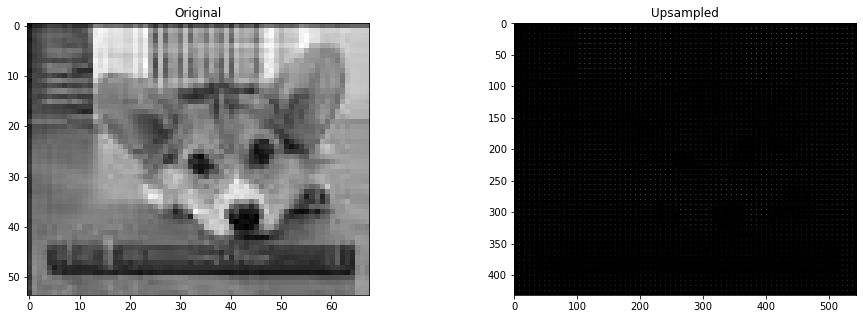

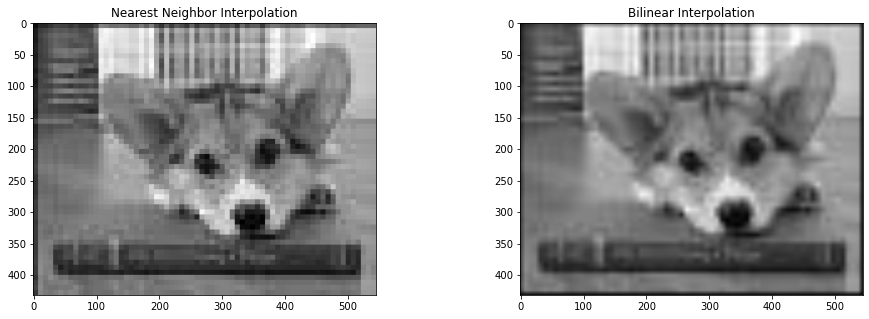

In [39]:
# Fill in this function for part 3.a:
def upsample_image(U, img):
    n_rows, n_cols = img.shape
    up_img = np.zeros((n_rows*U, n_cols*U))
    up_img[::U,::U] = img # stores every U element
    
    return up_img

# Fill in this function for part 3.b
# Assume x has already been upsampled
def nn(U, x):
    filter = []
    length = len(x)
    
    for i in range(U):
        filter.append(1)      
    x = np.convolve(x, filter) 
    
    return x[:length]

# Fill in this function for part 3.c:
# Assume x has already been upsampled
def linear(U, x):
    length = len(x)
    filter = []
    
    for i in range(2 * U + 1):
        filter.append((1 - abs(i - U) / U))
    x = np.convolve(x, filter)
    
    return x[U:U + length]

# Code for part 3.a:
small_img = imread('small-img.jpg')
upsample = upsample_image(8, small_img)

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.title("Original")
plt.imshow(small_img,'gray')
plt.subplot(122)
plt.title("Upsampled")
plt.imshow(upsample,'gray')

# Test signal for parts 3.b and 3.c:
test_signal = np.array([1, 0, 0, 10, 0, 0, 4, 0, 0]) #U = 3

# Code for part 3.b:
print("The signal before nearest neighbor interpolation:", test_signal)
print("The signal after nearest neighbor interpolation:", nn(3, test_signal))

# Code for part 3.c:
print("The signal before linear interpolation:", test_signal)
print("The signal after linear interpolation:", linear(3, test_signal))

# Code for part 3.d:
up_nn = upsample_image(8, small_img)
row_nn = np.zeros(up_nn.shape)
col_nn = np.zeros(up_nn.shape)
n_rows_nn, n_cols_nn = up_nn.shape

for i in range(n_rows_nn):
    row_nn[i, :] = nn(8, up_nn[i, :])
for j in range(n_cols_nn):
    col_nn[:, j] = nn(8, row_nn[:, j])


up_lr = upsample_image(8, small_img)
row_lr = np.zeros(up_lr.shape)
col_lr = np.zeros(up_lr.shape)
n_rows_lr, n_cols_lr = up_lr.shape

for i in range(n_rows_lr):
    row_lr[i, :] = linear(8, up_lr[i, :])
for j in range(n_cols_lr):
    col_lr[:, j] = linear(8, row_lr[:, j])
    

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.imshow(col_nn,'gray')
plt.title("Nearest Neighbor Interpolation")
plt.subplot(122)
plt.imshow(col_lr,'gray')
plt.title("Bilinear Interpolation")


## Comments here

Part 3(d):

When we use nearest neighbor interpolation, the resulting image is very close to the original imgae, which seems very pixelated. When we use bilinear interpolation, the resulting image is blured and seems more smooth/continuous.


## Least Squares and Linear Regression

Many fields of signal processing work with optimization problems know as least squares problems. A least square problem may be stated many different ways. One common such way is as follows: suppose we have $N$ input/output pairs where $(x_i,y_i)$ is the $i$'th such pair, $x_i$ is $P$-dimensional and $y_i$ is a scalar. The least squares problem may be given by:

$$
\min_{w} \frac{1}{N}\sum_{i=1}^N (w^\top x_i - y_i)^2
$$

Intuitively, the least squares problem is asking for the vector $w$ that minimizes the sum of our squared errors or, equivalently, our mean squared error (MSE) across all $N$ input/output pairs where we estimate $y_i$ from $\sum_{j=1}^p x[p]w[p]$. In any context, we would like to minimize the sum of our squared errors or equivalently, our mean squared error (MSE). In vectorized form, the least squares problem may be stated as

$$
\min_{w} \frac{1}{N}\lVert Xw - Y\rVert^2,
$$

where $X$ is an $N\times P$ matrix, $w$ is a length $P$ vector, $Y$ is a length $N$ vector, and $\lVert\cdot\rVert$ is the L2 norm (Euclidean distance).

### Linear Regression

One excellent example of a least squares problem is linear regression. Conceptually, linear regression seeks to find a "line of best fit" for a given set of data points. The image below illustrates a linear regression solution.

<img src="linear-regression.png" style="width: 500px;"/>

The notion of "best" line is defined by a least squares problem for $N$ data points

$$
\large{\min_{w,b} \frac{1}{N}\sum_{i=1}^N (x_iw + b - y_i)^2},
$$

where $w$ is the slope of our line and $b$ is our y-intercept and our input data is one-dimensional. We may again formulate our least squares problem in a vectorized form:

$$
\min_{\vec{w}} \frac{1}{N}\lVert X\vec{w} - Y\rVert^2,
$$

where $\vec{w} = [w,b]$ and $X$ is augmented with a column of ones. Thus $X$ looks like the following

$$
X = \begin{bmatrix}
x_1 & 1\\
x_2 & 1\\
\vdots \\
x_n & 1\\
\end{bmatrix}.
$$

Take a couple minutes to verify the summation and vectorized formulations of the problems are equivalent! Furthermore, it is important to note the importance of the intercept $b$ and the resulting augmentation of the matrix $X$ to accommodate the intercept. Without this intercept, we would only be able to express solutions that pass through the origin of our cooridnate system. In this case, the intercept value allows us to express any line in the $x-y$ plane. Recall from our discussion of adaptive filtering in Lab 6 that we may minimize our objective function by setting its gradient with respect to $\vec{w}$ to zero. This derivation is as follows:

$$
\nabla_{\vec{w}}\frac{1}{N}\lVert X\vec{w} - Y\rVert^2 = \frac{2}{N}X^\top(X\vec{w} - Y) = 0
$$

$$
X^\top X\vec{w} = X^\top Y
$$

$$
\vec{w} = \left(X^\top X\right)^{-1}X^\top Y
$$

Remember that $X^\top$ above refers to the transpose of the matrix $X$ and $X^{-1}$ refers to the inverse of a matrix. Thus, we have our solution vector in a relatively simple, closed form. Now, let's try applying this solution to a linear regression problem!

## Exercise 4: Linear Regression

We have provided four datasets in the files ``winter-data.csv``, ``spring-data.csv``, ``summer-data.csv``, and ``fall-data.csv`` that capture the high and low temperatures of each day in Champaign, IL for each season in 2017. Therefore, each dataset has roughly 90 low, high temperature pairs. We would like to apply linear regression to predict the high temperature for a given day using only knowledge of the low temperature for that day (low temperatures are $X$, high temperatures are $Y$). Furthermore, it may be interesting to see which season's low temperatures are most predictive of their high temperatures. 

We have provided the code below that loads the data for each season. Note that the loaded data for the low temperatures already has a "1" appended to each row to augment the data for linear regression. We have also provided a function in $\textrm{visualize_solution()}$ that plots the provided seasonal temperature data along with your linear regression solution. Refer to the below documentation on how to use this function.

a. Fill in the function $\textrm{linear_regression}()$ which takes the low temperature data and high temperature data and computes the solution to the linear regression problem. Refer to the previous technical background which gives the closed form solution. Also, fill in the function $\textrm{mse}()$ which takes the low and high temperature data and your linear regression solution to compute the mean squared error (MSE) for your solution. Note that the MSE is the same as evaluating the least-squares objective using your solution.

b. Compute the linear regression solution and corresponding mean squared error for Winter. Plot the data and your solution using the provided function and print the mean squared error.

c. Compute the linear regression solution and corresponding mean squared error for Spring. Plot the data and your solution and print the mean squared error.

d. Compute the linear regression solution and corresponding mean squared error for Summer. Plot the data and your solution and print the mean squared error.

e. Compute the linear regression solution and corresponding mean squared error for Fall. Plot the data and your solution and print the mean squared error.

f. In which season is it easiest to predict the high temperature from the low temperature? Which season is the hardest? Do these results surprise you? Do you have any theories or ideas to explain the results?

In [40]:
def load_temp_data(season_string):
    file_name = season_string + '.npy'
    data = np.load(file_name)
    lows = np.zeros(data.shape)
    lows[:,0] = data[:,0]
    lows[:,1] = np.ones(data.shape[0]) #augment column of ones
    highs = data[:,1]
    return lows, highs

winter_lows, winter_highs = load_temp_data('winter')
spring_lows, spring_highs = load_temp_data('spring')
summer_lows, summer_highs = load_temp_data('summer')
fall_lows, fall_highs = load_temp_data('fall')

The mean squared error for Winter is 69.71576908363453
The mean squared error for Spring is 51.27564085101072
The mean squared error for Summer is 19.454565150071677
The mean squared error for Fall is 58.87896918882463


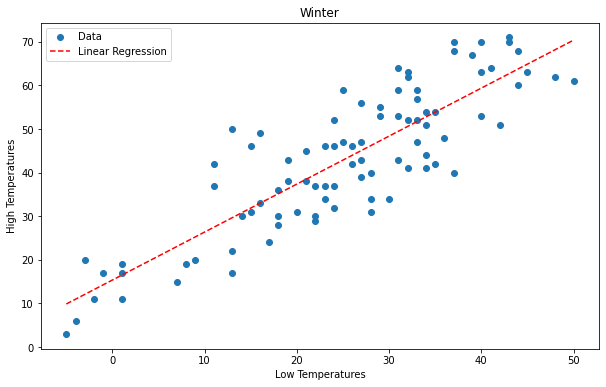

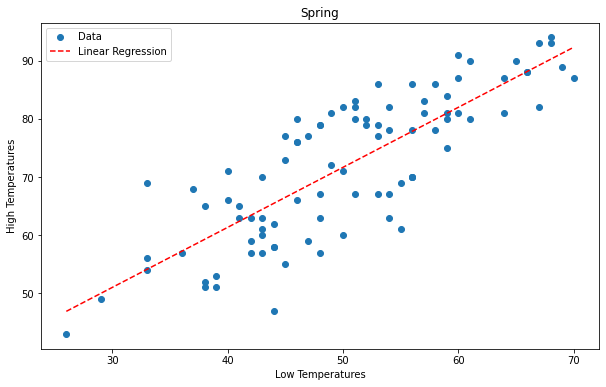

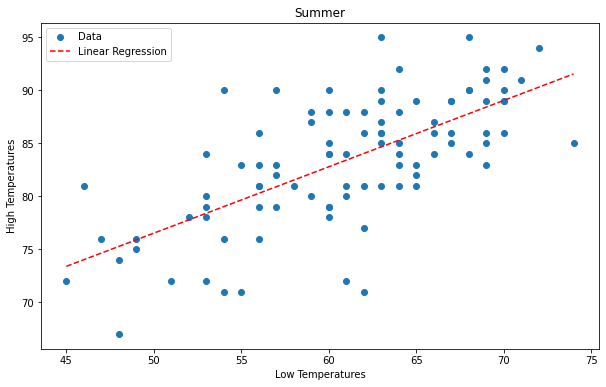

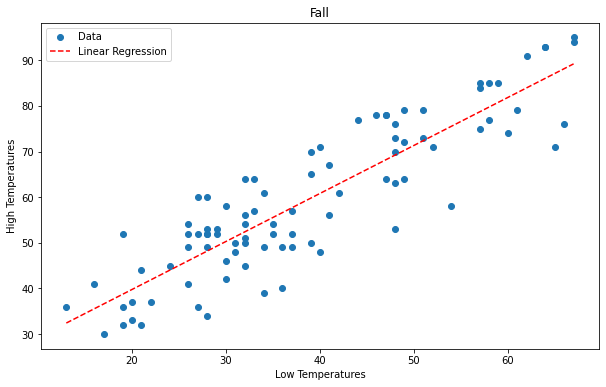

In [46]:
# Provided function
"""
Inputs:
low_data - One-augmented low temperature data for the given season.
high_data - High temperature data for the given season.
w - Solution vector for the given season (Should be length two!).
title - String for the title of your plot.

Example usage: visualize_solution(winter_low,winter_highs,winter_w,'Winter Solution and Data')
"""
def visualize_solution(low_data, high_data, w, title):
    if len(w) != 2:
        print('Incorrect solution dimension!')
        return
    min_low = np.min(low_data[:,0])
    max_low = np.max(low_data[:,0])
    x = np.linspace(min_low, max_low, 1000)
    y = w[0]*x + w[1]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.scatter(low_data[:,0], high_data, label='Data')
    plt.plot(x, y, 'r--', label='Linear Regression')
    plt.xlabel('Low Temperatures')
    plt.ylabel('High Temperatures')
    plt.legend()

# Fill in these functions for part 4.a:    
def linear_regression(low, high):
    # Hint: use np.linalg.inv() to invert a matrix
    low_transpose = np.transpose(low)
    w = np.linalg.inv(low_transpose.dot(low)).dot(low_transpose).dot(high)
    
    return w

def mse(low, high, w):
    # Hint: use np.linalg.norm()
    mse = (1 / len(high)) * np.linalg.norm(np.matmul(low, w) - high, 2) ** 2

    return mse

# Code for 4.b:
winter_linear_regression = linear_regression(winter_lows, winter_highs)
winter_mse = mse(winter_lows, winter_highs, winter_linear_regression)
visualize_solution(winter_lows, winter_highs, winter_linear_regression, "Winter")
print("The mean squared error for Winter is", winter_mse)

# Code for 4.c:
spring_linear_regression = linear_regression(spring_lows, spring_highs)
spring_mse = mse(spring_lows, spring_highs, spring_linear_regression)
visualize_solution(spring_lows, spring_highs, spring_linear_regression, "Spring")
print("The mean squared error for Spring is", spring_mse)

# Code for 4.d:
summer_linear_regression = linear_regression(summer_lows, summer_highs)
summer_mse = mse(summer_lows, summer_highs, summer_linear_regression)
visualize_solution(summer_lows, summer_highs, summer_linear_regression, "Summer")
print("The mean squared error for Summer is", summer_mse)

# Code for 4.e:
fall_linear_regression = linear_regression(fall_lows, fall_highs)
fall_mse = mse(fall_lows, fall_highs, fall_linear_regression)
visualize_solution(fall_lows, fall_highs, fall_linear_regression, "Fall")
print("The mean squared error for Fall is", fall_mse)


## Comments here

Part 4(f):

Summer is the easiest to predict since it has the least mean square error and Winter season is the hardest since it has the largest mean square error. I didn't have any expectations on which season would be the easiest or hardest to predict, but this does somewhat make sense. The temperature is influenced a lot by the weather patterns like snow storms and precipitation, while there aren't many weather events in the summer that can drastically influence the temperature. 
